In [1]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Option Pricing with Neural Networks

In this project, we aim to see how well a neural network can approximate the price of an option undercertain models, first we compare it with the analytical form of a Black Scholes call, then we'll see how it performs on different models like Heston where we will generate the price numerically and train the network on them.

The first step in any ML project is to well define the setup, so our features and our target variable.

## Part 1: Finding Black Scholes Call Prices with Neural Network - Analytical Form

Let us define the input features $\mathbf{x} \in \mathbb{R}^6$ as:

- $S$ : Current stock price
- $K$ : Strike price of the option
- $T$ : Time to maturity
- $r$ : Risk-free interest rate
- $r$ : continuous dividend yield
- $\sigma$ : Volatility of the underlying asset

These features are sufficient to compute the theoretical Black-Scholes price for a European call option with dividends.

We denote the feature vector as:

$$
\mathbf{x} = [S, K, T, r, q, \sigma]
$$


The target **Y** is the **Black-Scholes price of the European call** option with continuous dividend yield, denoted by:

$$
y = S e^{-qT} \cdot \Phi(d_1) - K e^{-rT} \cdot \Phi(d_2)
$$

We can define the loss function as follow:

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \left( C_{i} - f_\theta(\mathbf{x}^{(i)}) \right)^2
$$

where:

- $\theta$ are the trainable parameters of the neural network,
- $f_\theta(\mathbf{x}^{(i)}) = \hat{y}^{(i)}$ is the model prediction for input $\mathbf{x}^{(i)}$,
- $C_{i}$ is the target value, i.e., the Black-Scholes price for that input,
- $N$ is the number of training samples.

We take the mean so that the gradient is independant of the sample size and it makes it more stable.

In [2]:
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

# eg for one price given the 6 parameters
S, K, T, r, q, sigma = 100, 100, 1, 0.05, 0, 0.2
black_scholes_call(S, K, T, r, q, sigma)

np.float64(10.450583572185565)

Now we generate 5000 x 6 parameters as inputs and compute the analytical 5000 correponding prices that we use to train the network

In [3]:
## Dataset generation
n_samples = 5000
S = np.random.uniform(80, 120, n_samples)
K = np.random.uniform(80, 120, n_samples)
T = np.random.uniform(0.1, 2.0, n_samples)
sigma = np.random.uniform(0.1, 0.5, n_samples)
r = np.random.uniform(0.0, 0.05, n_samples)
q = np.random.uniform(0.0, 0.03, n_samples)

X = np.stack([S, K, T, sigma, r, q], axis=1)
y = black_scholes_call(S, K, T, sigma, r, q)

# Feature normalization for better gradient learning
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

X_tensor = torch.tensor(X_norm, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

Backpropagation on weights and biases on a mini batch of size B for a layer n

<img src="Backpropagation.jpeg" alt="Backpropagation" width="75%"/>



In [4]:
class BlackScholesNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(6, 64)     # 6 inputs → 64
        self.hidden2 = nn.Linear(64, 64)    # 64 → 64
        self.output = nn.Linear(64, 1)      # 64 → 1 (le prix)

        self.activation = nn.ReLU()         

    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.output(x)                  
        return x

model = BlackScholesNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 300
for epoch in range(n_epochs):
    model.train()                           
    
    optimizer.zero_grad()                 
    outputs = model(X_tensor)              
    loss = criterion(outputs, y_tensor)    

    loss.backward()                     
    optimizer.step()                        

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 912.4656
Epoch 100, Loss: 167.9720
Epoch 200, Loss: 22.2981


In [5]:
with torch.no_grad():
    preds = model(X_tensor)
    preds_np = preds.numpy()

example_idx = np.random.randint(0, n_samples, 3)

print('Now comparing the real analytical prices with what the Neural Network learned for 3 randomly chosen prices\n')
for i in example_idx:
    params = X[i]
    print(f"Set {i}: S={params[0]:.2f}, K={params[1]:.2f}, T={params[2]:.2f}, "
          f"σ={params[3]:.2f}, r={params[4]:.2f}, q={params[4]:.2f}")
    print(f"   True Price      : {y[i]:.2f}")
    print(f"   NN Prediction   : {preds_np[i][0]:.2f}\n")


Now comparing the real analytical prices with what the Neural Network learned for 3 randomly chosen prices

Set 1227: S=102.14, K=86.41, T=0.80, σ=0.47, r=0.02, q=0.02
   True Price      : 41.05
   NN Prediction   : 38.52

Set 3481: S=83.00, K=90.60, T=1.08, σ=0.28, r=0.04, q=0.04
   True Price      : 11.77
   NN Prediction   : 10.36

Set 2769: S=96.45, K=111.73, T=1.52, σ=0.29, r=0.01, q=0.01
   True Price      : 23.12
   NN Prediction   : 19.60



## Part 2 - Finding Price for Local Volatility Model - No analytical form

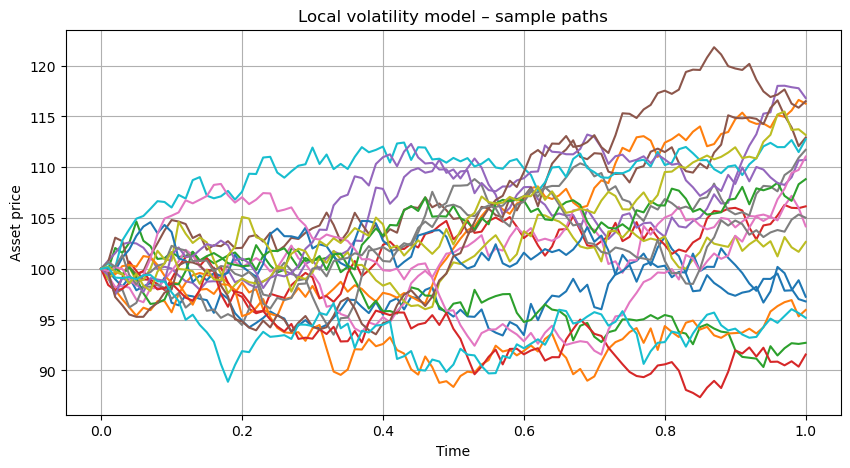

In [6]:
def sigma_loc(S, sigma_0, eps=1e-2):
    return sigma_0 / (S + eps)

def simulation_local_vol(S0, K, T, r, q, N, sigma_0, n_paths=500, return_paths=False):
    dt = T / N
    time_grid = np.linspace(0, T, N+1)
    S = np.zeros((n_paths, N+1))
    S[:, 0] = S0

    for i in range(N):
        sigma = sigma_loc(S[:, i], sigma_0)
        Z = np.random.normal(size=n_paths)
        S[:, i+1] = S[:, i] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Payoff for European Call
    payoffs = np.maximum(S[:, -1] - K, 0)
    discounted = np.exp(-r * T) * payoffs
    option_price = np.mean(discounted)

    if return_paths:
        return option_price, time_grid, S
    else:
        return option_price

price, time_grid, paths = simulation_local_vol(S0=100, K=100, T=1, r=0.05, q=0, N=100, sigma_0=10, return_paths=True)

plt.figure(figsize=(10, 5))
for i in range(20):
    plt.plot(time_grid, paths[i])
plt.title("Local volatility model – sample paths")
plt.xlabel("Time")
plt.ylabel("Asset price")
plt.grid(True)
plt.show()

And now the goal is to: 

- Take a set of parameters
- simulate N paths with them
- take the discounted mean of the payoffs to price the option corresponding to these parameters
- repeat for another set of parameters until we have enough option prices
- train the neural network on these prices to find a link between the parameters and the prices

In [7]:
n_samples = 5000
n_paths = 1000
N = 100

S0_vals = np.random.uniform(80, 120, n_samples)
K_vals  = np.random.uniform(80, 120, n_samples)
T_vals  = np.random.uniform(0.1, 2.0, n_samples)
r_vals  = np.random.uniform(0.0, 0.1, n_samples)
q_vals  = np.random.uniform(0.0, 0.05, n_samples)
sigma_0_vals = np.random.uniform(5, 20, n_samples)

X = np.vstack([S0_vals, K_vals, T_vals, r_vals, q_vals, sigma_0_vals]).T
y = []

print('Computing numerical prices with Monte Carlo')
for i in tqdm(range(n_samples)):
    S0, K, T, r, q, sigma_0 = X[i]

    option_price = simulation_local_vol(S0, K, T, r, q, N, sigma_0, n_paths)
    y.append(option_price)

y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

class OptionPricingNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = OptionPricingNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

batch_size = 64
n_epochs = 300

for epoch in range(n_epochs):
    idx = torch.randperm(n_samples)

    for i in range(0, n_samples, batch_size):
        batch_idx = idx[i:i+batch_size]
        X_batch = X_tensor[batch_idx]
        y_batch = y_tensor[batch_idx]

        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch:02d} — Loss: {loss.item():.4f}")

idx = np.random.choice(n_samples, size=3, replace=False)
X_sample = X_tensor[idx]
y_sample = y_tensor[idx].squeeze().numpy()

model.eval()
with torch.no_grad():
    y_pred = model(X_sample).squeeze().numpy()

for i in range(3):
    print(f"Params: {X[idx[i]]}")
    print(f"Monte Carlo: {y_sample[i]:.4f} — NN: {y_pred[i]:.4f}")
    print("---")

Computing numerical prices with Monte Carlo


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:27<00:00, 181.92it/s]


Epoch 00 — Loss: 20.1922
Epoch 100 — Loss: 0.5242
Epoch 200 — Loss: 0.2047
Epoch 299 — Loss: 0.1911
Params: [1.02045641e+02 1.00641968e+02 8.72878747e-01 6.47212456e-02
 2.42371508e-03 6.76937425e+00]
Monte Carlo: 7.2855 — NN: 6.5111
---
Params: [9.56849521e+01 8.29799542e+01 1.65158873e+00 4.13115073e-02
 2.69844969e-02 1.62095963e+01]
Monte Carlo: 16.6251 — NN: 15.8276
---
Params: [1.01930531e+02 8.95431158e+01 1.66923508e+00 5.05197512e-02
 4.98505874e-02 1.87301030e+01]
Monte Carlo: 15.4649 — NN: 15.3577
---


## Part 3 - Finding price for Heston Model

### Heston Model

The **Heston model** is a popular stochastic volatility model used to describe the evolution of an asset price and its volatility over time. Unlike the Black-Scholes model, where volatility is constant, the Heston model assumes that volatility follows its own stochastic process.

The model captures important market features like **volatility clustering** and the **volatility smile** observed in option prices.

### Model Dynamics

Under the risk-neutral measure, the Heston model is defined by the following stochastic differential equations:

$$
\begin{aligned}
dS_t &= (r - q) S_t \, dt + \sqrt{\sigma_t} S_t \, dW_t^S, \\\\
d\sigma_t &= \kappa (\theta - \sigma_t) \, dt + \xi \sqrt{\sigma_t} \, dW_t^v, \\\\
dW_t^S \cdot dW_t^v &= \rho \, dt.
\end{aligned}
$$

- $S_t$: asset price at time $t$
- $\sigma_t$: instantaneous variance (i.e., stochastic volatility)
- $r$: risk-free interest rate
- $q$: continuous dividend yield
- $\kappa$: speed of mean reversion
- $\theta$: long-run average variance
- $\xi$: volatility of volatility
- $\rho$: correlation between asset and volatility shocks



To simulate the Heston model, we discretize the continuous-time SDEs using the **Euler-Maruyama scheme** with correlated Brownian motions.

Let $\Delta t = \frac{T}{N}$ be the time step, and define the Brownian increments as:

$$
\begin{aligned}
Z_t^S &\sim \mathcal{N}(0, 1), \\\\
Z_t^v &= \rho Z_t^S + \sqrt{1 - \rho^2} \cdot \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, 1)
\end{aligned}
$$

Then, the Brownian increments over each time step are:

$$
\begin{aligned}
dW_t^S &= \sqrt{\Delta t} \cdot Z_t^S, \\\\
dW_t^v &= \sqrt{\Delta t} \cdot Z_t^v
\end{aligned}
$$

The discretized equations become:

$$
\begin{aligned}
v_{t+\Delta t} &= \max\left\{ v_t + \kappa (\theta - v_t) \Delta t + \xi \sqrt{v_t} \cdot dW_t^v, \; 0 \right\}, \\\\
S_{t+\Delta t} &= S_t \cdot \exp\left[ \left( r - \tfrac{1}{2} v_t \right) \Delta t + \sqrt{v_t} \cdot dW_t^S \right]
\end{aligned}
$$

We use **full truncation** to ensure that the variance \(v_t\) remains non-negative throughout the simulation.


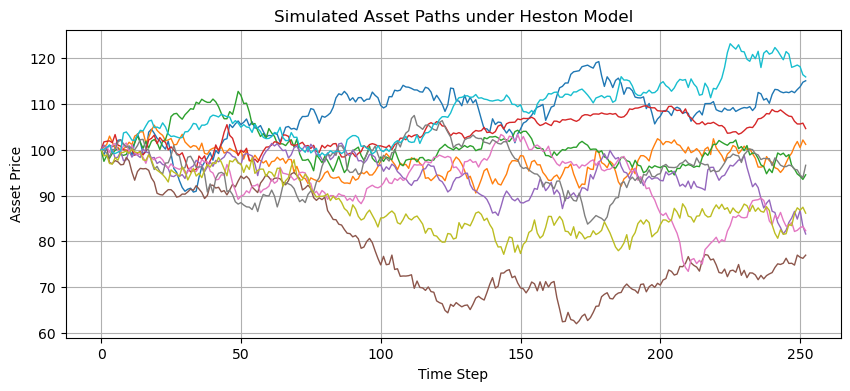

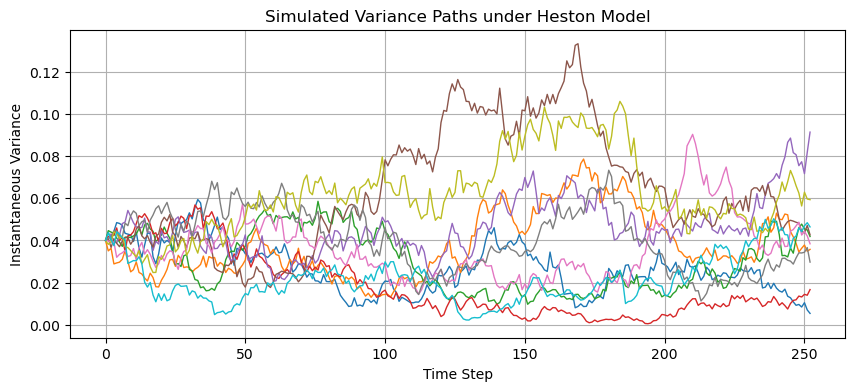

In [8]:
def simulate_heston_paths(S0, v0, r, kappa, theta, xi, rho, T, steps=100, n_paths=1000):
    dt = T / steps
    S = np.zeros((n_paths, steps + 1))
    v = np.zeros((n_paths, steps + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, steps + 1):
        Z1 = np.random.randn(n_paths)
        Z2 = np.random.randn(n_paths)
        dW1 = np.sqrt(dt) * Z1
        dW2 = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)

        v_prev = np.maximum(v[:, t-1], 0)
        v[:, t] = v[:, t-1] + kappa * (theta - v_prev) * dt + xi * np.sqrt(v_prev) * dW2
        v[:, t] = np.maximum(v[:, t], 0)

        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v_prev) * dt + np.sqrt(v_prev) * dW1)
    
    return S, v


S_paths, v_paths = simulate_heston_paths(S0=100, v0=0.04, r=0.02, kappa=2.0, theta=0.04, xi=0.3, rho=-0.7,T=1.0, steps=252, n_paths=10)

plt.figure(figsize=(10, 4))
for i in range(S_paths.shape[0]):
    plt.plot(S_paths[i], lw=1)
plt.title("Simulated Asset Paths under Heston Model")
plt.xlabel("Time Step")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
for i in range(v_paths.shape[0]):
    plt.plot(v_paths[i], lw=1)
plt.title("Simulated Variance Paths under Heston Model")
plt.xlabel("Time Step")
plt.ylabel("Instantaneous Variance")
plt.grid(True)
plt.show()


In [9]:
# Generating dataset
n_samples = 5000
S0 = np.random.uniform(80, 120, size=n_samples)
v0 = np.random.uniform(0.01, 0.1, size=n_samples)
T = np.random.uniform(0.1, 2.0, size=n_samples)
kappa = np.random.uniform(1, 5, size=n_samples)
theta = np.random.uniform(0.02, 0.1, size=n_samples)
xi = np.random.uniform(0.1, 0.5, size=n_samples)
rho = np.random.uniform(-0.9, 0.9, size=n_samples)
r = np.random.uniform(0.0, 0.05, size=n_samples)

X = np.column_stack([S0, v0, T, kappa, theta, xi, rho, r])
y = []

print('Computing numerical prices with Monte Carlo')
for i in tqdm(range(n_samples)):
    S_paths, _ = simulate_heston_paths(S0[i], v0[i], r[i],kappa[i], theta[i], xi[i], rho[i], T[i])
    K = S0[i]  # option ATM
    
    payoff = np.maximum(S_paths[:, -1] - K, 0)
    price = np.exp(-r[i] * T[i]) * np.mean(payoff)
    y.append(price)

y = np.array(y).reshape(-1, 1)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

X_tensor = torch.tensor(X_norm, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

class HestonNet(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        return self.model(x)

batch_size = 64
n_epochs = 300
N = X_tensor.shape[0]

model = HestonNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    indices = torch.randperm(N)
    X_shuffled = X_tensor[indices]
    y_shuffled = y_tensor[indices]

    epoch_loss = 0

    for i in range(0, N, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        # Forward + backward + update
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.shape[0]

    epoch_loss /= N
    losses.append(epoch_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: MSE = {epoch_loss:.4f}")


idx = np.random.choice(len(X_tensor), size=3, replace=False)
X_sample = X_tensor[idx]
y_true = y_tensor[idx]
model.eval()
with torch.no_grad():
    y_pred = model(X_sample)

for i in range(3):
    print(f"Sample {i+1}")
    print(f"  Inputs: {X[idx[i]]}")  # les features non-normalisées
    print(f"  True Price (MC): {y_true[i].item():.4f}")
    print(f"  Predicted Price (NN): {y_pred[i].item():.4f}")
    print()


Computing numerical prices with Monte Carlo


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.84it/s]


Epoch 0: MSE = 67.6122
Epoch 100: MSE = 0.3240
Epoch 200: MSE = 0.2897
Sample 1
  Inputs: [ 1.12762826e+02  3.89378692e-02  1.95959617e+00  1.06803087e+00
  9.20154097e-02  1.27957089e-01 -7.23393515e-02  1.14627932e-02]
  True Price (MC): 16.5760
  Predicted Price (NN): 16.7893

Sample 2
  Inputs: [ 1.11978139e+02  4.01214435e-02  1.20772786e+00  4.42591150e+00
  3.38815366e-02  3.61829070e-01 -5.05515906e-01  3.23216225e-02]
  True Price (MC): 10.5805
  Predicted Price (NN): 10.7397

Sample 3
  Inputs: [ 9.04507349e+01  7.45585049e-02  1.44238506e+00  2.27317320e+00
  9.52662941e-02  2.32226758e-01 -7.29297624e-01  3.75347482e-02]
  True Price (MC): 15.5634
  Predicted Price (NN): 15.1589

